In [1]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')
data = [train, test]
ids = test.iloc[:,0]

In [3]:
for dset in data:
    dset['FSize'] = dset.SibSp + dset.Parch + 1 
print(train[['FSize','Survived']].groupby(['FSize']).mean())

       Survived
FSize          
1      0.303538
2      0.552795
3      0.578431
4      0.724138
5      0.200000
6      0.136364
7      0.333333
8      0.000000
11     0.000000


In [4]:
for dset in data:
    dset['Alone'] = 0
    dset.loc[dset['FSize'] == 1, 'Alone'] = 1

print(train[['Alone', 'Survived']].groupby('Alone').mean())

       Survived
Alone          
0      0.505650
1      0.303538


In [5]:
for dset in data:
    dset['Embarked'] = dset['Embarked'].fillna('S')
print(train[['Embarked', 'Survived']].groupby('Embarked').mean())

          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009


In [6]:
for dset in data:
    dset['Fare'] = dset['Fare'].fillna(train['Fare'].median())
    
train['CatFare'] = pd.qcut(train['Fare'],4)
print(train[['CatFare', 'Survived']].groupby('CatFare').mean())

                 Survived
CatFare                  
(-0.001, 7.91]   0.197309
(7.91, 14.454]   0.303571
(14.454, 31.0]   0.454955
(31.0, 512.329]  0.581081


In [7]:
for dset in data:
    age_avg = train.Age.mean()
    age_std = train.Age.std()
    age_null_count = dset.Age.isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dset.Age[np.isnan(dset.Age)] = age_null_random_list
    dset.Age = dset.Age.astype(int)
    
train['CatAge'] = pd.cut(train.Age, 5)

print(train[['CatAge','Survived']].groupby('CatAge').mean())

               Survived
CatAge                 
(-0.08, 16.0]  0.517857
(16.0, 32.0]   0.365688
(32.0, 48.0]   0.355469
(48.0, 64.0]   0.434783
(64.0, 80.0]   0.090909


In [8]:
import re

In [9]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dset in data:
    dset['Title'] = dset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [10]:
for dset in data:
    dset['Title'] = dset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dset['Title'] = dset['Title'].replace('Mlle', 'Miss')
    dset['Title'] = dset['Title'].replace('Ms', 'Miss')
    dset['Title'] = dset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())



    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [11]:
for dataset in data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FSize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CatAge', 'CatFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

In [12]:
from sklearn.preprocessing import OneHotEncoder as ohe

In [13]:
y = train.Survived
train.drop(['Survived'], axis=1,inplace=True)

In [14]:
onehot_encoder = ohe(sparse=False)
train_encoded = pd.DataFrame(onehot_encoder.fit_transform(train))
test_encoded = pd.DataFrame(onehot_encoder.fit_transform(test))

In [15]:
train_1 = train_encoded.values
test_1  = test_encoded.values

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

('KNeighborsClassifier', 0.7899999999999998)
('SVC', 0.7888888888888888)
('DecisionTreeClassifier', 0.8111111111111111)
('RandomForestClassifier', 0.8088888888888889)
('AdaBoostClassifier', 0.8111111111111111)
('GradientBoostingClassifier', 0.818888888888889)
('GaussianNB', 0.7355555555555555)
('LinearDiscriminantAnalysis', 0.8011111111111111)
('QuadraticDiscriminantAnalysis', 0.6477777777777778)
('LogisticRegression', 0.8111111111111111)


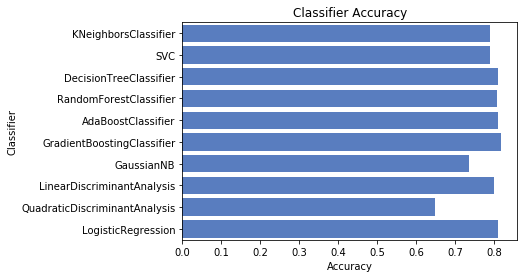

In [17]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train_1
# y = y

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:

    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
for item in acc_dict.items():
    print(item)

In [18]:
candidate_classifier = GradientBoostingClassifier()
candidate_classifier.fit(train,y )
result = candidate_classifier.predict(test)

In [19]:
frame = pd.DataFrame(result) 
frame.columns = ['Survived']
frame.insert(frame.shape[1]-1, 'PassengerID', ids)

frame.to_csv('pred.csv',index=False)